In [43]:
#read file

def ReadFile(data_set_number):
    
    if data_set_number==0:
        file_path = 'a280-n1395.txt'
    elif data_set_number==1:    
        file_path = 'a280-n279.txt'
    elif data_set_number==2: 
        file_path = 'a280-n2790.txt'
    elif data_set_number==3: 
        file_path = 'fnl4461-n22300.txt'
    elif data_set_number==4: 
        file_path = 'fnl4461-n4460.txt'
    elif data_set_number==5:  
        file_path = 'fnl4461-n44600.txt'
    elif data_set_number==6: 
        file_path = 'pla33810-n169045.txt'
    elif data_set_number==7: 
        file_path = 'pla33810-n33809.txt'
    elif data_set_number==8: 
         file_path = 'pla33810-n338090.txt'

    with open(file_path, 'r') as file:

        file_content = file.readlines()

    problem_info = {}
    node_coord_section = []
    items_section=[]

    for line in file_content:
        line = line.strip()
        if line.startswith('PROBLEM NAME:'):
            problem_info['PROBLEM_NAME'] = line.split(':')[-1].strip()
            
        elif line.startswith('KNAPSACK DATA TYPE:'):
            problem_info['KNAPSACK_DATA_TYPE'] = line.split(':')[-1].strip()
            
        elif line.startswith('DIMENSION:'):
            problem_info['DIMENSION'] = int(line.split(':')[-1].strip())
           
        elif line.startswith('NUMBER OF ITEMS:'):
            problem_info['NUMBER_OF_ITEMS'] = int(line.split(':')[-1].strip())
            
        elif line.startswith('CAPACITY OF KNAPSACK:'):
            problem_info['CAPACITY_OF_KNAPSACK'] = int(line.split(':')[-1].strip())

        elif line.startswith('MIN SPEED:'):
            problem_info['MIN_SPEED'] = float(line.split(':')[-1].strip())
            
        elif line.startswith('MAX SPEED:'):
            problem_info['MAX_SPEED'] = float(line.split(':')[-1].strip())
          
        elif line.startswith('RENTING RATIO:'):
            problem_info['RENTING_RATIO'] = float(line.split(':')[-1].strip())
            
        elif line.startswith('EDGE_WEIGHT_TYPE:'):
            problem_info['EDGE_WEIGHT_TYPE'] = line.split(':')[-1].strip()
            
        elif line.startswith('NODE_COORD_SECTION'):
            break

    for line in file_content[len(problem_info) + 1:]:

        if line.startswith('ITEMS SECTION'):
            break

        if line.strip():
            index, x, y = map(int, line.split())
            node_coord_section.append((index, x, y))


    for line in file_content[len(node_coord_section)+len(problem_info) +2 :]:
        if line.strip():
            index, x, y, z = map(int, line.split())
            items_section.append((index, x, y,z))
    
#     print(problem_info)#--------test
#     print(node_coord_section)#--------test
#     print(items_section)#--------test
    
    dimension = problem_info['DIMENSION']
    number_of_items= problem_info['NUMBER_OF_ITEMS']
    capacity_of_knapsack = problem_info['CAPACITY_OF_KNAPSACK']
    min_speed = problem_info['MIN_SPEED']
    max_speed = problem_info['MAX_SPEED']
    renting_ration=problem_info['RENTING_RATIO']
    
    return  dimension,\
            number_of_items,\
            capacity_of_knapsack,\
            min_speed,max_speed,\
            renting_ration,\
            node_coord_section,\
            items_section

In [44]:
#Class Item

class Item:
    
    def __init__(self, item_number, value, weight,city_number,score):
        
        self.number = item_number
        self.value  = value
        self.weight = weight
        self.cost_performance = round(value/weight,4)
        self.city_number = city_number
        self.score = score
    def __lt__(self, other):
        return self.score < other.score    
    def __eq__(self, other):
        if isinstance(other, Item):
            return self.number == other.number
        return False

In [45]:
#Class TTPsolution

class TTPsolution:
    
    def __init__(self,value,cost_time,weight,city_list,pack_plan):
        
        self.solution_value = value
        self.solution_cost_time = cost_time
        self.solution_weight = weight
        self.solution_path = city_list
        self.solution_pack_plan = pack_plan


In [46]:
#BuildItemsList
def BuildItemsList(items_section):
    
    items_list=[]
    
    for item in items_section:
        
        item_number=item[0]
        value=item[1]
        weight=item[2]
        city_number=item[3]
        score=0
        
        temp=Item(item_number, value, weight,city_number,score)
        items_list.append(temp)
    
    return items_list

In [47]:
#BuildDistanceMatrix 
##return matrix[i][j] = distance--city i to city j
def BuildDistanceMatrix(city_number,node_coord_section):
    
    matrix=[]
    for i in range(city_number):        
        row = []
        for j in range(city_number):            
            if i == j:                
                row.append(0)
            else:        
                x1,y1=node_coord_section[i][1],node_coord_section[i][2]
                x2,y2=node_coord_section[j][1],node_coord_section[j][2]
                distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                distance_rounded = round(distance, 5)
                row.append(distance_rounded)

#                 print(i,x1,y1)------------test
#                 print(j,x2,y2)
#                 print(distance)
                
        matrix.append(row)
        
    return matrix


In [48]:
#BuildCityItemsDict
#return city_item_dict[1]=[1,2,3]----Dictionary city1 have 1,2,3 items
def BuildCityItemsDict(city_number,items_section):
    
    city_item_dict={}
    
    for i in range(city_number):
        
        every_item_in_city=[]
        
        for item in items_section:
            
            if item[3]==i+1:
                
                item_number=item[0]
                item_value=item[1]
                item_weight=item[2]
                
                #Initialize the pheromone
                item_pheromone = 1
                score=0
                temp = Item(item_number,item_value,item_weight,item_pheromone,score)
                every_item_in_city.append(temp)
                
        city_item_dict[i+1] = every_item_in_city
        
    return city_item_dict         

In [49]:
#Initial_distance_Pheromone,Heuristic and update
def InitialisDistancePheromone(city_number):
    matrix=[]
    for i in range(city_number):
        row=[]
        for j in range(city_number):
            
            if i==j:
                temp=0
            else:
                temp=1
                
            row.append(temp)
            
        matrix.append(row)
    return matrix    

def InitialisDistanceHeuristic(city_number,distance_matrix):
    
    matrix=[]
    for i in range(city_number):
        row=[]
        for j in range(city_number):
            
            if i==j:
                temp=0
            else:
                if distance_matrix[i][j] != 0:
                    temp=round(1/distance_matrix[i][j],4)
                else:
                    temp=0
            row.append(temp)
            
        matrix.append(row)
    return matrix   

def UpdateDistanceHeuristic(current_distance_heuristic,city_number,current_city):
    
    for i in range(city_number):
        for j in range(city_number):
            if j==current_city:
                current_distance_heuristic[i][j]=0
def UpdatePheromone(evaporation_rate,current_distance_pheromone,city_number,ant_number,all_solution,distance_matrix):
    
    for ant in range(ant_number):
        
        sum=0
        
        for i in range(len(all_solution[ant].solution_path)):
            
            temp1=all_solution[ant].solution_path[i]
            temp3=all_solution[ant].solution_path[0]
            
            if i != len(all_solution[ant].solution_path)-1:
                
                temp2=all_solution[ant].solution_path[i+1]
                sum += distance_matrix[temp1][temp2]
                        
            sum += distance_matrix[temp1][temp3]
                        
        for i in range(city_number):
            for j in range(city_number):
                current_distance_pheromone[i][j]=round((1-evaporation_rate)*current_distance_pheromone[i][j]+1/sum,4)
    
    

In [50]:
#calculate Transition probabilities
#return next city 
def TransitionProbabilities(travel_city_list,city_number,current_distance_pheromone,\
                            current_distance_heuristic,alpha,beta):
    
   
    current_city = travel_city_list[-1]
    #print(current_city)
    probability_list = [0]*city_number
    
    #Initialize the possibility matrix
    for i in range(city_number):
        temp1 = current_distance_pheromone[current_city][i]
        temp2 = current_distance_heuristic[current_city][i]

        probability_list[i] = temp1 ** alpha * temp2 ** beta
    
    sum_ = 0
    for i in range(city_number):
        sum_ += probability_list[i]

    sum_pro = 0
    
    for i in range(city_number):
        
        sum_pro += (probability_list[i]/ sum_)
        
        probability_list[i]=sum_pro

    rand = random.random()

    for i in range(city_number):
        if probability_list[i]>= rand:
                return i
    

In [51]:
#calculate CurrentSpeed
def CurrentSpeed(v_max,v_min,capacity_of_knapsack,current_weight):
    speed = None
    if current_weight<=capacity_of_knapsack:
        speed= v_max - ((current_weight/capacity_of_knapsack)*(v_max-v_min))
    else:
        speed=v_min 
    if speed :
        return speed
    else:
        print("speed calculate is wrong")    

In [52]:
#UpdateBestSolution
def UpdateBestSolution(best_solution, ant_solution):
    
    if best_solution==[]:
        #print("first")
        best_solution.append(ant_solution)
    
    else:
        
        #Make sure this point is added, 0 abandon,1-in
        add_sign=1
        pop_list=[]
        
        for i in range(len(best_solution)):
            
            #The point is completely dominated
            if  ant_solution.solution_value < best_solution[i].solution_value \
                and ant_solution.solution_cost_time > best_solution[i].solution_cost_time:
                
                add_sign=0
                break
                
            #One past point is completely dominated
            elif  ant_solution.solution_value >= best_solution[i].solution_value \
                and ant_solution.solution_cost_time <= best_solution[i].solution_cost_time:
                pop_list.append(i)
                
        for i in reversed(pop_list):
            best_solution.pop(i)
            #print("pop")
        if add_sign==1:
            #print("add")
            best_solution.append(ant_solution)
                

In [53]:
# the Chained Lin-Kernighan heuristic
#score =pα/(wα × di)
def ScoreSystem(alpha_choose,items_list,path_distance_dict):
    
    items_list_copy = copy.deepcopy(items_list)
    
    for item in range(len(items_list_copy)):
        
        current_city = items_list_copy[item].city_number-1

        items_list_copy[item].score=(items_list_copy[item].value**alpha_choose)\
        /((items_list_copy[item].weight**alpha_choose)*path_distance_dict[current_city])
    
    sorted_items_list = sorted(items_list_copy, key=lambda x: x.score)

    return sorted_items_list
# µ = bm/τ c,

def calculateDistanceToEnd(path,distance_matrix):
    distance_end=[]
    path_distance_dict={}
    distance_to_end=0
    
    for i in range(len(path)-1, -1, -1):
        
        if i == len(path) - 1:
            distance_to_end = distance_matrix[path[i]][path[0]]
        else:
            distance_to_end += distance_matrix[path[i]][path[i+1]]
        
        path_distance_dict[path[i]]= distance_to_end
        
    return path_distance_dict

def calculate_total_profit(path,current_pack, distance_matrix, v_max, v_min, max_weight, R):
    
    current_pack1 = copy.deepcopy(current_pack)
    total_profit = 0
    total_weight = 0
    pack_city={}
    v = (v_max - v_min) / max_weight
        
    for i in range(len(current_pack1)):
        
        total_weight+=current_pack1[i].weight
        total_profit+=current_pack1[i].value
        if current_pack1[i].city_number in pack_city:
            pack_city[current_pack1[i].city_number] +=current_pack1[i].weight
        else:
            pack_city[current_pack1[i].city_number] =current_pack1[i].weight
    current_weight=0
    cost_time=0
    
    for i in range(len(path)):
        distance=0
        if i != len(path)-1:
            distance= distance_matrix[path[i]][path[i+1]]
        else:
            distance= distance_matrix[path[i]][path[0]]
            
        if path[i] in pack_city:  
            
            current_weight+=pack_city[path[i]]
            
        current_speed = v_max -current_weight * v
        cost_time +=distance/current_speed    
        
    cost_time=round(cost_time,4)
    total_profit -= round(R * cost_time,4)
    
    return total_profit,cost_time

def CalculateWeight(current_pack):
    weight=0
    for i in range(len(current_pack)):
        weight+=current_pack[i].weight
    return weight
        
    
def PackPlan(alpha_choose,f_control,solution,number_of_items,items_list,distance_matrix,max_weight\
            , v_max, v_min, R):
    
    frequency_control = number_of_items/f_control
    
    current_weight = 0
    path=solution.solution_path
    path_distance_dict = calculateDistanceToEnd(path,distance_matrix)
    score_items_list = ScoreSystem(alpha_choose,items_list,path_distance_dict)

    Z_max = float('-inf')
    current_pack=[]
    best_pack=[]
    k=0
    k_best=0
    profit=0

 
    while (current_weight < max_weight) and (frequency_control> 1):
        if (current_weight + score_items_list[k].weight <= max_weight):
            current_pack.append(score_items_list[k])
            current_weight +=score_items_list[k].weight
     
            if k % frequency_control == 0:
                profit,cost_time = calculate_total_profit(path,current_pack, distance_matrix, v_max, v_min, max_weight, R)
                
                if profit < Z_max:
                    current_pack = copy.deepcopy(best_pack)
                    current_weight=CalculateWeight(current_pack)
                    frequency_control = frequency_control/2
                    k = k_best
                else:    
                    best_pack = copy.deepcopy(current_pack)
                    k_best=k
                    Z_max=profit
        k+=1
        
    profit,cost_time = calculate_total_profit(path,current_pack, distance_matrix, v_max, v_min, max_weight, R) 
    return current_pack,profit,cost_time

    #Bitflip
    best_pack = copy.deepcopy(current_pack)
    Z_max = profit
    
    for i in range(len(items_list)):
        if items_list[i] in best_pack:
            best_pack.remove(items_list[i])
            current_pack=copy.deepcopy(best_pack)
        else:
            best_pack.append(items_list[i])
            current_pack=copy.deepcopy(best_pack)

        profit_,cost_time = calculate_total_profit(path,current_pack, distance_matrix, v_max, v_min, max_weight, R)
        if profit_>Z_max:
            Z_max=profit_
            best_pack=copy.deepcopy(current_pack)
    
    profit1,cost_time1 = calculate_total_profit(path,best_pack, distance_matrix, v_max, v_min, max_weight, R) 
    #print(best_pack[0].number)
    #print("111",profit1,cost_time1)
    return best_pack,profit1,cost_time1
    
    
    
    
    


In [54]:
#ant_colony
class AntColony:
    
    def __init__(self,ant_number,iteration,alpha, beta,evaporation_rate,pheromone_max,pheromone_min,city_number,\
               number_of_items, capacity_of_knapsack, min_speed, max_speed,\
               renting_ration,distance_matrix,city_items_dict,alpha_choose,f_control,items_list):
        
        self.ant_number = ant_number
        self.iteration = iteration
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.city_number = city_number
        self.number_of_items = number_of_items
        self.capacity_of_knapsack = capacity_of_knapsack
        self.min_speed = min_speed
        self.max_speed = max_speed
        self.renting_ration=renting_ration
        self.distance_matrix = distance_matrix
        self.city_items_dict = city_items_dict  
        self.alpha_choose=alpha_choose
        self.f_control=f_control
        self.items_list=items_list
    def run(self):
        
        best_solution = []

        current_distance_pheromone = InitialisDistancePheromone(self.city_number)

        for iterate in range(self.iteration):  
            
            all_solution=[]
            ant=0
            for ant_ in range(self.ant_number):
                
                #----------------------one ant start------------------------              
                travel_city_list=[]
                current_distance_heuristic = InitialisDistanceHeuristic(self.city_number,distance_matrix)
                #random find start city
                current_city = random.randint(0, self.city_number-1)
                travel_city_list.append(current_city)
                UpdateDistanceHeuristic(current_distance_heuristic,self.city_number,current_city)
 
                for i in range(self.city_number-1):
                #-----------------------ant go to cities-------------------------
                    next_city = TransitionProbabilities(travel_city_list,self.city_number,current_distance_pheromone,\
                                                                current_distance_heuristic,self.alpha,self.beta)
                    current_city=next_city
                    travel_city_list.append(current_city)
                    UpdateDistanceHeuristic(current_distance_heuristic,self.city_number,current_city)
                    
                print("the",iterate+1, "iteration",ant+1,"ant finish")
                #-------------------------one ant finish-----------------------------
                #-----create TTP solution-----
                #print(travel_city_list)
                current_weight = 0
                current_value = 0
                cost_time =  0
                travel_package=[]
                
                ant_solution = TTPsolution(current_value,cost_time,current_weight,travel_city_list,travel_package)
                all_solution.append(ant_solution)
                ant+=1
            #-------------------------------every ants finished------------------------
            for i in range(len(all_solution)):
               
                pack_plan,profit,cost_time = PackPlan(self.alpha_choose,self.f_control,all_solution[i],self.number_of_items,\
                         self.items_list,self.distance_matrix,self.capacity_of_knapsack,self.max_speed, self.min_speed, self.renting_ration)
                all_solution[i].solution_value=profit
                all_solution[i].solution_pack_plan=pack_plan
                all_solution[i].solution_cost_time=cost_time
                #print(all_solution[i].solution_value,all_solution[i].solution_cost_time)
                UpdateBestSolution(best_solution, all_solution[i])
                #print(len(best_solution))
            UpdatePheromone(evaporation_rate,current_distance_pheromone,self.city_number,self.ant_number,all_solution,distance_matrix)

        return best_solution
        

In [55]:
#show data
def ShowData(best_solution):
    
    for i in range(len(best_solution)):
        temp_1 = best_solution[i].solution_value
        temp_2 = best_solution[i].solution_cost_time
        color = plt.cm.viridis(i / len(best_solution))  
        plt.scatter(temp_2, temp_1, color=color)
    
    plt.title('Value & Cost Time')
    plt.xlabel('Cost Time')
    plt.ylabel('Value')
    

    plt.show()    

the 1 iteration 1 ant finish
the 1 iteration 2 ant finish
the 1 iteration 3 ant finish
the 1 iteration 4 ant finish
the 1 iteration 5 ant finish
the 1 iteration 6 ant finish
the 1 iteration 7 ant finish
the 1 iteration 8 ant finish
the 1 iteration 9 ant finish
the 1 iteration 10 ant finish
the 2 iteration 1 ant finish
the 2 iteration 2 ant finish
the 2 iteration 3 ant finish
the 2 iteration 4 ant finish
the 2 iteration 5 ant finish
the 2 iteration 6 ant finish
the 2 iteration 7 ant finish
the 2 iteration 8 ant finish
the 2 iteration 9 ant finish
the 2 iteration 10 ant finish
the 3 iteration 1 ant finish
the 3 iteration 2 ant finish
the 3 iteration 3 ant finish
the 3 iteration 4 ant finish
the 3 iteration 5 ant finish
the 3 iteration 6 ant finish
the 3 iteration 7 ant finish
the 3 iteration 8 ant finish
the 3 iteration 9 ant finish
the 3 iteration 10 ant finish
the 4 iteration 1 ant finish
the 4 iteration 2 ant finish
the 4 iteration 3 ant finish
the 4 iteration 4 ant finish
the 4 itera

the 28 iteration 7 ant finish
the 28 iteration 8 ant finish
the 28 iteration 9 ant finish
the 28 iteration 10 ant finish
the 29 iteration 1 ant finish
the 29 iteration 2 ant finish
the 29 iteration 3 ant finish
the 29 iteration 4 ant finish
the 29 iteration 5 ant finish
the 29 iteration 6 ant finish
the 29 iteration 7 ant finish
the 29 iteration 8 ant finish
the 29 iteration 9 ant finish
the 29 iteration 10 ant finish
the 30 iteration 1 ant finish
the 30 iteration 2 ant finish
the 30 iteration 3 ant finish
the 30 iteration 4 ant finish
the 30 iteration 5 ant finish
the 30 iteration 6 ant finish
the 30 iteration 7 ant finish
the 30 iteration 8 ant finish
the 30 iteration 9 ant finish
the 30 iteration 10 ant finish
the 31 iteration 1 ant finish
the 31 iteration 2 ant finish
the 31 iteration 3 ant finish
the 31 iteration 4 ant finish
the 31 iteration 5 ant finish
the 31 iteration 6 ant finish
the 31 iteration 7 ant finish
the 31 iteration 8 ant finish
the 31 iteration 9 ant finish
the 31 

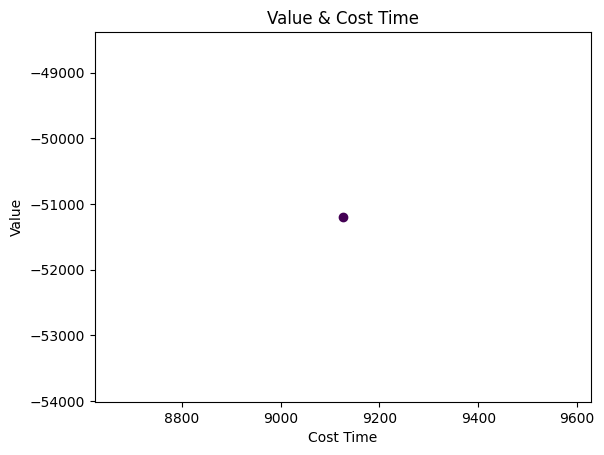

In [56]:
#mian function
import math
import random
import copy
import matplotlib.pyplot as plt
#----------------------------------------Extract data from a file-----------------------------

# print(f"""
#     a280-n1395:0
#     a280-n279:1
#     a280-n2790:2
#     fnl4461-n22300:3
#     fnl4461-n4460:4
#     fnl4461-n44600:5
#     pla33810-n169045:6
#     pla33810-n33809:7
#     pla33810-n338090:8
# """)
#the data set number
#data_set_number = input("Please enter the data set number:")
#ReadFile(data_set_number)

txt_data= ReadFile(1) #----------test

city_number, number_of_items, capacity_of_knapsack, min_speed, max_speed, renting_ration, node_coord_section,\
items_section = txt_data

distance_matrix = BuildDistanceMatrix(city_number,node_coord_section)

city_items_dict = BuildCityItemsDict(city_number,items_section)

items_list = BuildItemsList(items_section)

#----------------------------------------Start ant colony-----------------------------

ant_number=10
iteration=50
evaporation_rate=0.5
alpha=1
beta=2
pheromone_max=0.5
pheromone_min=0
alpha_choose=0.5
f_control= 1395


ant_colony = AntColony(ant_number,iteration,alpha,beta,evaporation_rate,pheromone_max,\
                       pheromone_min,city_number,number_of_items,capacity_of_knapsack, min_speed, max_speed,\
                       renting_ration,distance_matrix,city_items_dict,alpha_choose,f_control,items_list)
        
best_solution=ant_colony.run()
print(len(best_solution))
#show best solution
ShowData(best_solution)
